In [1]:
%load_ext autoreload
from cartpole import *

In [ ]:
transition_counts = mdp_data['transition_counts']
reward_counts = mdp_data['reward_counts']
num_states = mdp_data['num_states']
transition_probs = mdp_data['transition_probs']

In [2]:
mdp_data = initialize_mdp_data(5)

In [4]:
update_mdp_transition_counts_reward_counts(mdp_data, 0, 1, 2, -1)
update_mdp_transition_counts_reward_counts(mdp_data, 0, 1, 4, 0)
print(mdp_data)

{'transition_counts': array([[[0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 1.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]]), 'transition_probs': array([[[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]],

       [[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]]]), 'reward_counts': array([[0., 0.],
       [0., 0.],
       [2., 2.],
       [0., 0.],
       [0., 1.]]), 'reward': array([0., 0., 0., 0., 0.]), 'value': array([0.09594323, 0.00816562, 0.07117691, 0.0699182 , 0.01792118]), 'num_states': 5}


In [8]:
from env import *

In [10]:
cart = CartPole(Physics())

In [30]:
cart.get_state((0, 0, 0.1, 1))

148

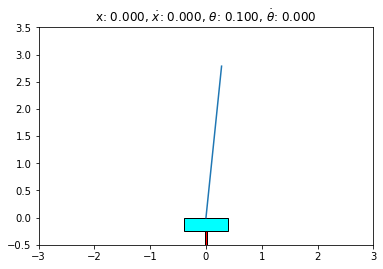

In [33]:
cart.show_cart((0, 0, 0.1, 1), 0.01)

In [ ]:

# Simulation parameters
pause_time = 0.0001
min_trial_length_to_start_display = 100
display_started = min_trial_length_to_start_display == 0

NUM_STATES = 163
GAMMA = 0.995
TOLERANCE = 0.01
NO_LEARNING_THRESHOLD = 20

# Time cycle of the simulation
time = 0

# These variables perform bookkeeping (how many cycles was the pole
# balanced for before it fell). Useful for plotting learning curves.
time_steps_to_failure = []
num_failures = 0
time_at_start_of_current_trial = 0

# You should reach convergence well before this
max_failures = 500

# Initialize a cart pole
cart_pole = CartPole(Physics())

# Starting `state_tuple` is (0, 0, 0, 0)
# x, x_dot, theta, theta_dot represents the actual continuous state vector
x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
state_tuple = (x, x_dot, theta, theta_dot)

# `state` is the number given to this state, you only need to consider
# this representation of the state
state = cart_pole.get_state(state_tuple)
# if min_trial_length_to_start_display == 0 or display_started == 1:
#     cart_pole.show_cart(state_tuple, pause_time)

mdp_data = initialize_mdp_data(NUM_STATES)

# This is the criterion to end the simulation.
# You should change it to terminate when the previous
# 'NO_LEARNING_THRESHOLD' consecutive value function computations all
# converged within one value function iteration. Intuitively, it seems
# like there will be little learning after this, so end the simulation
# here, and say the overall algorithm has converged.

consecutive_no_learning_trials = 0
while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:

    action = choose_action(state, mdp_data)

    # Get the next state by simulating the dynamics
    state_tuple = cart_pole.simulate(action, state_tuple)
    # x, x_dot, theta, theta_dot = state_tuple

    # Increment simulation time
    time = time + 1

    # Get the state number corresponding to new state vector
    new_state = cart_pole.get_state(state_tuple)
    # if display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    # reward function to use - do not change this!
    if new_state == NUM_STATES - 1:
        R = -1
    else:
        R = 0

    update_mdp_transition_counts_reward_counts(mdp_data, state, action, new_state, R)

    # Recompute MDP model whenever pole falls
    # Compute the value function V for the new model
    if new_state == NUM_STATES - 1:

        update_mdp_transition_probs_reward(mdp_data)

        converged_in_one_iteration = update_mdp_value(mdp_data, TOLERANCE, GAMMA)

        if converged_in_one_iteration:
            consecutive_no_learning_trials = consecutive_no_learning_trials + 1
        else:
            consecutive_no_learning_trials = 0

    # Do NOT change this code: Controls the simulation, and handles the case
    # when the pole fell and the state must be reinitialized.
    if new_state == NUM_STATES - 1:
        num_failures += 1
        if num_failures >= max_failures:
            break
        print('[INFO] Failure number {}'.format(num_failures))
        time_steps_to_failure.append(time - time_at_start_of_current_trial)
        # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
        time_at_start_of_current_trial = time

        if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
            display_started = 1

        # Reinitialize state
        # x = 0.0
        x = -1.1 + np.random.uniform() * 2.2
        x_dot, theta, theta_dot = 0.0, 0.0, 0.0
        state_tuple = (x, x_dot, theta, theta_dot)
        state = cart_pole.get_state(state_tuple)
    else:
        state = new_state